# Find picture in picture


In order to identify important layout elements or structures in a document, pictures can be compared directly and smaller images can be detected in larger pictures. This is done in this example in order to identify tables in a newspaper.

Installation instruction for conda environment:

    conda install numpy matplotlib jupyter
    conda install opencv
    conda install imutils

First import all required packages

In [1]:
# general tools
import os, sys
import numpy as np

In [2]:
import cv2

In [3]:
from IPython.display import Image

In [4]:
import matplotlib.pyplot as plt

In [5]:
import imutils

## Subroutines

The best match for a given picture is found iteratively. The subroutines doing the iterations for improving the match and finding the best rotation angle are defined here.

In [6]:
# find best matching subpicture
def find_picture_match(img_rgb, template, init_thrs, step, loc, w, h):
    thrs = init_thrs
    n_loc = len(loc[0])
    while (thrs < 1.0 and n_loc > 0):
        res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
        threshold = thrs
        old_loc = loc
        loc = np.where(res >= threshold)
        n_loc = len(loc[0])
        thrs += step
        if n_loc < 1:
            loc = old_loc
    print('iteration converged at threshold = ', (thrs-step))
    print('number of matches found: ', len(loc[0]))
    return loc, thrs-step

In [7]:
# find best matching rotation
def find_rotation_match(img_rgb, template, init_rot, end_rot, rot_step, thrs):
    rotation = init_rot-rot_step
    n_loc = 0
    n_arr = []
    while (rotation <= end_rot):
        rotation += rot_step
        rotated = imutils.rotate(template, rotation)
        res = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= thrs)
        n_loc = len(loc[0])
        #print(rotation, n_loc)
        n_arr.append(n_loc)
    np_n_arr = np.array(n_arr)
    #print('maximum of matches found upon rotation: ', np.max(n_arr))
    if np.max(n_arr) == 0:
        print('no matches found upon rotation')
        rotation = 0.0
    else:
        rotation = init_rot + (np.argmax(np_n_arr)*rot_step)
    #print ('rotation_angle = ', rotation)
    return rotation

## find picture

find the best match for the table from the template picture in the journal page

In [8]:
# select template and journal page
#img_rgb = cv2.imread('05-13-1842.png')
img_rgb = cv2.imread('12-23-1842.png')
#img_rgb = cv2.imread('11-04-1842.png')
#template = cv2.imread('meteorologische.png')
#template = cv2.imread('whole_table.png')
template = cv2.imread('template.png')

In [9]:
# initialize variables for iterations
init_thrs = 0.07 # initial threshold
step = 0.01 # step for increasing threshold
w, h = template.shape[:-1]
res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= init_thrs)
n_loc = len(loc[0])
print ('initial matches found : ', n_loc)

initial matches found :  1738


In [10]:
# run subroutine for iterative picture matching
location, threshold = find_picture_match(img_rgb, template, init_thrs, step, loc, w, h)

iteration converged at threshold =  0.2900000000000001
number of matches found:  3


In [11]:
# these are the best matching locations
image = (location[::-1])
image

(array([179, 180, 180]), array([116, 116, 117]))

In [12]:
# select one location for cropping
crop_img = img_rgb[int(image[1][0]):int(image[1][0]+w), int(image[0][0]):int(image[0][0]+h)]

In [13]:
# save to file
result_name = 'result.png'
cv2.imwrite(result_name, crop_img)

True

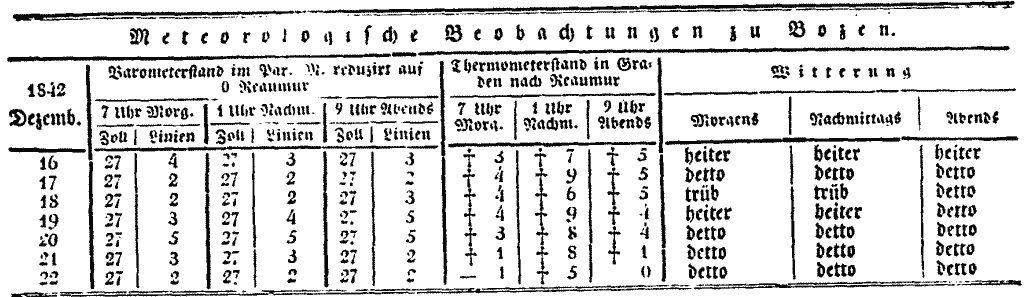

In [14]:
# what did we find?
Image(filename=result_name) 

### find optimal rotation

The picture may be rotated with respect to the template. We use the final threshold from above in order to find the optimal rotation.

In [15]:
init_rot = -2.0 # initial rotation angle
end_rot = 2.0 # final rotation angle
rot_step = 0.25 # rotation step
init_thrs = threshold # threshold 
print (init_thrs)
result2_name = 'result2.png'

0.2900000000000001


In [16]:
# find best matching rotation
rotation = find_rotation_match(img_rgb, template, init_rot, end_rot, rot_step, init_thrs)

In [17]:
# rotate by selected angle and initialize
rotated = imutils.rotate(template, rotation)
w, h = rotated.shape[:-1]
res = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= init_thrs)
n_loc = len(loc[0])
print ('rotation = ', rotation, ' instances found : ', n_loc)

rotation =  0.75  instances found :  68


In [18]:
location, threshold = find_picture_match(img_rgb, rotated, init_thrs, step, loc, w, h)

iteration converged at threshold =  0.5700000000000003
number of matches found:  1


In [19]:
image = (location[::-1])
image
print (len(image[0]))

1


In [20]:
# crop image with some extra borders
tol = 0.05 # 5 % extra border at each side
w_border = int(w*tol)
h_border = int(h*tol)
if len(image[0]) != 0:
    crop_img = img_rgb[int(image[1][0]-w_border):int(image[1][0]+w+w_border), int(image[0][0]-h_border):int(image[0][0]+h+h_border)]
    rot_crop_img = imutils.rotate(crop_img, -rotation) # invert rotation for result (rotation applies to template)
    cv2.imwrite(result2_name, rot_crop_img)
else:
    print ('no matches found, therefore no new locations; keep image without rotation')
    cv2.imwrite(result2_name, crop_img)

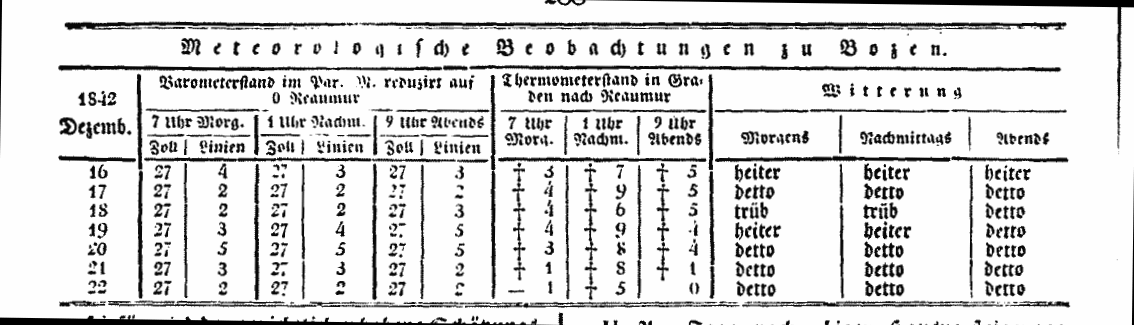

In [21]:
Image(filename=result2_name) 

## loop over whole year

Now we repeat this for several journal pages. please adapt the definitions in the field below accordingly.

In [22]:
# define template and location of journal pages here
template = cv2.imread('template.png')  # template
image_dir = './bozner_zeitung_1842'   # location of journal pages
result_dir = './bz_1842_results'   # results

In [23]:
# initialize variables
init_thrs = 0.07 # initial threshold
step = 0.01 # step for increasing threshold
w, h = template.shape[:-1]
init_rot = -2.0 # initial rotation angle
end_rot = 2.0 # final rotation angle
rot_step = 0.25 # rotation step
tol = 0.05 # 5% extra border on each side
w_border = int(w*tol)
h_border = int(h*tol)

In [24]:
# create results folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

In [25]:
for filename in os.listdir(image_dir):
    img_rgb = cv2.imread(os.path.join(image_dir,filename))
    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= init_thrs)
    n_loc = len(loc[0])
    print (filename, 'initial instances found : ', n_loc)
    location, threshold = find_picture_match(img_rgb, template, init_thrs, step, loc, w, h)
    if threshold < 0.3:
        old_location = location
        thrs = threshold # threshold
        rotation = find_rotation_match(img_rgb, template, init_rot, end_rot, rot_step, thrs)
        rotated = imutils.rotate(template, rotation) # invert angle for rotating image
        res = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= thrs)
        n_loc = len(loc[0])
        print ('rotation = ', rotation, ' instances found : ', n_loc)
        location, threshold = find_picture_match(img_rgb, rotated, thrs, step, loc, w, h)
        image = (location[::-1])
        if len(image[0]) == 0:
            print ('no matches found, therefore no new locations; keep image without rotation')
            location = old_location
            image = (location[::-1])
        crop_img = img_rgb[int(image[1][0]-w_border):int(image[1][0]+w+w_border), int(image[0][0]-h_border):int(image[0][0]+h+h_border)]
        rot_crop_img = imutils.rotate(crop_img, -rotation) # invert rotation for result (rotation applies to template)
        result_name = os.path.join(result_dir,filename)
        cv2.imwrite(result_name, rot_crop_img)
    else:
        image = (location[::-1])
        border = int(min(w, h)*tol)
        crop_img = img_rgb[int(image[1][0]-w_border):int(image[1][0]+w+w_border), int(image[0][0]-h_border):int(image[0][0]+h+h_border)]
        result_name = os.path.join(result_dir,filename)
        cv2.imwrite(result_name, crop_img)
    print ('--------------------------------------------------------------------------------')

12-23-1842.png initial instances found :  1738
iteration converged at threshold =  0.2900000000000001
number of matches found:  3
rotation =  0.75  instances found :  68
iteration converged at threshold =  0.5700000000000003
number of matches found:  1
--------------------------------------------------------------------------------
11-11-1842.png initial instances found :  2240
iteration converged at threshold =  0.5100000000000002
number of matches found:  1
--------------------------------------------------------------------------------
01-07-1842.png initial instances found :  3
iteration converged at threshold =  0.08
number of matches found:  3
rotation =  -1.25  instances found :  5142
iteration converged at threshold =  0.17
number of matches found:  3
--------------------------------------------------------------------------------
05-27-1842.png initial instances found :  2214
iteration converged at threshold =  0.11999999999999998
number of matches found:  56
no matches found 

12-09-1842.png initial instances found :  1299
iteration converged at threshold =  0.3100000000000001
number of matches found:  2
--------------------------------------------------------------------------------
08-19-1842.png initial instances found :  1834
iteration converged at threshold =  0.3100000000000001
number of matches found:  2
--------------------------------------------------------------------------------
11-18-1842.png initial instances found :  2364
iteration converged at threshold =  0.5500000000000003
number of matches found:  1
--------------------------------------------------------------------------------
08-05-1842.png initial instances found :  2143
iteration converged at threshold =  0.4400000000000002
number of matches found:  2
--------------------------------------------------------------------------------
07-15-1842.png initial instances found :  2111
iteration converged at threshold =  0.3300000000000001
number of matches found:  2
--------------------------